<a href="https://colab.research.google.com/github/sundarp17/sundar_info5731_fall2020/blob/master/project/train/Highkappa_balanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd

train_kappa = pd.read_csv(r'/content/train_data_highkappa.csv')
train_kappa.head()

,Unnamed: 0,Sentence,Target
0,659,Appellant had stated to the officers that she ...,Invalid
1,3456,We shall discuss the facts more fully in conne...,Others
2,2043,"â€œPerjury is a false statement, either writte...",Invalid
3,3344,The offense is felony theft by false pretext; ...,Issue
4,3231,Numerous contentions urging the commission of ...,Issue


In [60]:
train_kappa['Target'].unique()

array(['Invalid', 'Others', 'Issue', 'Analysis', 'Facts', 'Conclusion',
       'Rule/Law/Holding'], dtype=object)

In [61]:
train_kappa['Target']=train_kappa['Target'].replace(['Others'],'Invalid')
train_kappa['Target'].unique()

array(['Invalid', 'Issue', 'Analysis', 'Facts', 'Conclusion',
       'Rule/Law/Holding'], dtype=object)

In [62]:
#cleaning
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('wordnet')
stopword=nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wl= WordNetLemmatizer()

def clean_text(text):
  text="".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+',text)
  text = [wl.lemmatize(word) for word in tokens if word not in stopword]
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer = clean_text)
X_tfidf = tfidf_vect.fit_transform(train_kappa['Sentence'])
print(X_tfidf.shape)


(2951, 5835)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=Invalid, n=1510 (16.667%)
Class=Issue, n=1510 (16.667%)
Class=Analysis, n=1510 (16.667%)
Class=Facts, n=1510 (16.667%)
Class=Conclusion, n=1510 (16.667%)
Class=Rule/Law/Holding, n=1510 (16.667%)


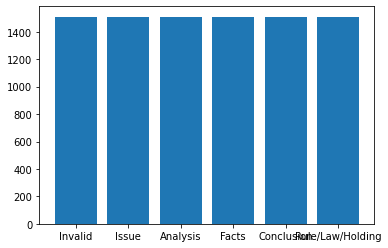

In [65]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
oversample = SMOTE(random_state=777,k_neighbors=5)
X, y = oversample.fit_resample(X_tfidf, train_kappa['Target'])
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.9420529801324503
                  precision    recall  f1-score   support

        Analysis       0.92      0.95      0.93       281
      Conclusion       0.96      0.99      0.97       328
           Facts       0.95      0.79      0.86       297
         Invalid       0.88      0.93      0.90       295
           Issue       0.97      1.00      0.99       308
Rule/Law/Holding       0.97      0.99      0.98       303

        accuracy                           0.94      1812
       macro avg       0.94      0.94      0.94      1812
    weighted avg       0.94      0.94      0.94      1812



In [127]:
test = pd.read_csv(r'/content/test_data.csv')
test.head()

,Unnamed: 0,Sentence,Target
0,2173,Darden Sr. testified â€œI saw he was staggerin...,Facts
1,466,Additional moral justification may have been d...,Analysis
2,525,"85, 22 S.W. 140, wherein the accused was actin...",Rule/Law/Holding
3,2199,Under a proper instruction from the court on m...,Facts
4,79,He is eligible for leaves to renew contacts wi...,Facts


In [71]:
test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
test['Sentence'] = test['Sentence'].str.replace('[^\w\s]','')
from nltk.corpus import stopwords
words = stopwords.words('english')
test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in words))

In [73]:
from textblob import TextBlob
from textblob import Word
nltk.download('wordnet')
nltk.download('punkt')
test['Sentence'] = test['Sentence'].apply(lambda x: TextBlob(x).words)
test['Sentence'] = test['Sentence'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [82]:
pred=tfidf_vect.transform(test['Sentence'])
predicted=sgd.predict(pred)
print('Accuracy %s' % accuracy_score(predicted,test['Target']))
print(classification_report(predicted,test['Target']))

Accuracy 0.5738963531669866
                  precision    recall  f1-score   support

        Analysis       0.45      0.38      0.41        93
      Conclusion       0.65      0.53      0.59        32
           Facts       0.66      0.78      0.72       226
         Invalid       0.60      0.38      0.46       103
           Issue       0.32      0.42      0.37        26
          Others       0.00      0.00      0.00         0
Rule/Law/Holding       0.59      0.49      0.53        41

        accuracy                           0.57       521
       macro avg       0.47      0.43      0.44       521
    weighted avg       0.59      0.57      0.57       521



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
del test['predicted']

In [86]:
unlabel_1 = test.loc[:100]
print("length of unlabel_1",len(unlabel_1))
unlabel_2 = test.loc[101:200]
print("length of unlabel_2",len(unlabel_2))
unlabel_3 = test.loc[201:300]
print("length of unlabel_3",len(unlabel_3))
unlabel_4 = test.loc[301:400]
print("length of unlabel_4",len(unlabel_4))
unlabel_5 = test.loc[401:]
print("length of unlabel_5",len(unlabel_5))

length of unlabel_1 101
length of unlabel_2 100
length of unlabel_3 100
length of unlabel_4 100
length of unlabel_5 120


In [87]:
x_un1 = tfidf_vect.transform(unlabel_1['Sentence'])
pred_unlabel_1 = sgd.predict(x_un1)
unlabel_1['Predicted']=pred_unlabel_1
unlabel_1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,Sentence,Target,Predicted
0,2173,darden sr testified âœi saw staggering â prett...,Facts,Facts
1,466,additional moral justification may due complai...,Analysis,Facts
2,525,85 22 sw 140 wherein accused acting upon advic...,Rule/Law/Holding,Invalid
3,2199,proper instruction court murder malice murder ...,Facts,Facts
4,79,eligible leaf renew contact family,Facts,Facts


In [128]:
test_target = test['Target']

In [129]:
test_target.head()

0               Facts
1            Analysis
2    Rule/Law/Holding
3               Facts
4               Facts
Name: Target, dtype: object

In [89]:

del unlabel_1['Target']
del unlabel_2['Target']
del unlabel_3['Target']
del unlabel_4['Target']
del unlabel_5['Target']

In [90]:
unlabel_1 = unlabel_1.rename(columns={'Predicted':'Target'})
unlabel_1.head()

,Unnamed: 0,Sentence,Target
0,2173,darden sr testified âœi saw staggering â prett...,Facts
1,466,additional moral justification may due complai...,Facts
2,525,85 22 sw 140 wherein accused acting upon advic...,Invalid
3,2199,proper instruction court murder malice murder ...,Facts
4,79,eligible leaf renew contact family,Facts


In [91]:
frame_1 = [train_kappa,unlabel_1]
train_1 = pd.concat(frame_1)
len(train_1)

3052

In [92]:
x_train_1 = tfidf_vect.transform(train_1['Sentence'])
X, y = oversample.fit_resample(x_train_1, train_1['Target'])
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print('Accuracy %s' % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.9320492241840557
                  precision    recall  f1-score   support

        Analysis       0.91      0.91      0.91       309
      Conclusion       0.95      0.98      0.96       317
           Facts       0.91      0.76      0.83       288
         Invalid       0.87      0.93      0.90       326
           Issue       0.97      1.00      0.99       315
Rule/Law/Holding       0.98      1.00      0.99       314

        accuracy                           0.93      1869
       macro avg       0.93      0.93      0.93      1869
    weighted avg       0.93      0.93      0.93      1869



In [93]:
x_un2 = tfidf_vect.transform(unlabel_2['Sentence'])
pred_unlabel_2 = sgd.predict(x_un2)
unlabel_2['Target']=pred_unlabel_2
unlabel_2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,Sentence,Target
101,1207,examination occurred night middle may testifie...,Facts
102,3400,undisputed testimony reflects appellant drivin...,Facts
103,2072,appellant testify offer evidence behalf,Facts
104,517,56 uniform act regulating traffic highway gist...,Invalid
105,906,agreed accompany gave pawn ticket money reclai...,Facts


In [94]:
frame_2 = [train_1,unlabel_2]
train_2 = pd.concat(frame_2)
len(train_2)

3152

In [98]:
x_train_2 = tfidf_vect.transform(train_2['Sentence'])
X, y = oversample.fit_resample(x_train_2, train_2['Target'])
X_train, x_val, Y_train, y_val = train_test_split(X,y,test_size=0.27,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_val)
print('Accuracy %s' % accuracy_score(pred_sgd,y_val))
print(classification_report(y_val,pred_sgd))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.930609097918273
                  precision    recall  f1-score   support

        Analysis       0.89      0.92      0.91       427
      Conclusion       0.97      0.97      0.97       454
           Facts       0.96      0.77      0.85       419
         Invalid       0.86      0.92      0.89       418
           Issue       0.95      1.00      0.97       437
Rule/Law/Holding       0.96      1.00      0.98       439

        accuracy                           0.93      2594
       macro avg       0.93      0.93      0.93      2594
    weighted avg       0.93      0.93      0.93      2594



In [99]:
x_un3 = tfidf_vect.transform(unlabel_3['Sentence'])
x_un3.shape
pred_unlabel_3 = sgd.predict(x_un3)
unlabel_3['Target']=pred_unlabel_3
unlabel_3.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,Sentence,Target
201,1882,find evidence amply sufficient sustain juryâs ...,Analysis
202,964,action show thatâ,Invalid
203,1417,certification attending physician shown filed ...,Facts
204,2932,testified agent bland first left automobile wa...,Facts
205,1584,officer testified could smell odor alcohol app...,Facts


In [100]:
frame_3 = [train_2,unlabel_3]
train_3 = pd.concat(frame_3)
len(train_3)

3252

In [102]:
x_train_3 = tfidf_vect.transform(train_3['Sentence'])
X, y = oversample.fit_resample(x_train_3, train_3['Target'])
X_train, x_val, Y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_val)
print('Accuracy %s' % accuracy_score(pred_sgd,y_val))
print(classification_report(y_val,pred_sgd))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.9326923076923077
                  precision    recall  f1-score   support

        Analysis       0.90      0.95      0.92       332
      Conclusion       0.96      0.99      0.97       348
           Facts       0.95      0.75      0.83       314
         Invalid       0.87      0.91      0.89       319
           Issue       0.97      0.99      0.98       353
Rule/Law/Holding       0.95      1.00      0.97       310

        accuracy                           0.93      1976
       macro avg       0.93      0.93      0.93      1976
    weighted avg       0.93      0.93      0.93      1976



In [103]:
x_un4 = tfidf_vect.transform(unlabel_4['Sentence'])
x_un4.shape
pred_unlabel_4 = sgd.predict(x_un4)
unlabel_4['Target']=pred_unlabel_4
unlabel_4.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,Sentence,Target
301,266,section 6 pl,Invalid
302,3469,amended answer appellant alleged bond invalid ...,Analysis
303,1471,evidence sufficient support conviction appella...,Analysis
304,1990,case cited note 19,Invalid
305,2757,july 8 1960 order entered revoking said probat...,Facts


In [117]:
frame_4 = [train_3,unlabel_4]
train_4 = pd.concat(frame_4)
len(train_4)
x_train_4 = tfidf_vect.transform(train_4['Sentence'])
X, y = oversample.fit_resample(x_train_4, train_4['Target'])
X_train, x_val, Y_train, y_val = train_test_split(X,y,test_size=0.18,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_val)
print('Accuracy %s' % accuracy_score(pred_sgd,y_val))
print(classification_report(y_val,pred_sgd))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.9299397920087575
                  precision    recall  f1-score   support

        Analysis       0.91      0.93      0.92       323
      Conclusion       0.96      0.99      0.97       326
           Facts       0.95      0.75      0.84       282
         Invalid       0.85      0.91      0.88       290
           Issue       0.96      0.99      0.97       303
Rule/Law/Holding       0.96      1.00      0.98       303

        accuracy                           0.93      1827
       macro avg       0.93      0.93      0.93      1827
    weighted avg       0.93      0.93      0.93      1827



In [118]:
x_un5 = tfidf_vect.transform(unlabel_5['Sentence'])
x_un5.shape
pred_unlabel_5 = sgd.predict(x_un5)
unlabel_5['Target']=pred_unlabel_5
unlabel_5.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,Sentence,Target
401,2979,overrule appellantâs contention court erred pe...,Conclusion
402,2135,state regarded authority case,Analysis
403,1591,testimony adduced appellant mother lillie mae ...,Issue
404,658,appellant needle mark inside left elbow,Facts
405,2562,analysis content 3 capsule chemist kenneth and...,Facts


In [123]:
frame_5 = [train_4,unlabel_5]
train_5 = pd.concat(frame_5)
len(train_5)
x_train_5 = tfidf_vect.transform(train_5['Sentence'])
X, y = oversample.fit_resample(x_train_5, train_5['Target'])
X_train, x_val, Y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_val)
print('Accuracy %s' % accuracy_score(pred_sgd,y_val))
print(classification_report(y_val,pred_sgd))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.931566265060241
                  precision    recall  f1-score   support

        Analysis       0.90      0.95      0.93       357
      Conclusion       0.97      0.99      0.98       363
           Facts       0.91      0.74      0.81       317
         Invalid       0.87      0.90      0.89       346
           Issue       0.97      0.99      0.98       353
Rule/Law/Holding       0.97      1.00      0.98       339

        accuracy                           0.93      2075
       macro avg       0.93      0.93      0.93      2075
    weighted avg       0.93      0.93      0.93      2075

